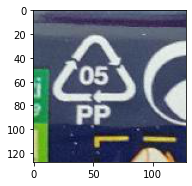

In [6]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

resolution = [128,128, 3]

source_dir = 'datasets'



def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def procces_img(path):
    img_tmp = Image.open(path).resize((resolution[0],resolution[1]))
    return np.array(img_tmp).astype('uint8')

def get_matrix_data(data, resolution, num):

    x_data = []

    for img in data:

        img_matrix = procces_img(f'{source_dir}/{int(num)}/{img}')
        
        x_data.append(img_matrix)
    
    return x_data



def transfrom_data(ratio, source_dir, resolution):

    tmp_train_x = []
    tmp_valid_x = []
    tmp_test_x = []

    train_dataset_x = np.array([])
    valid_dataset_x = np.array([])
    test_dataset_x = np.array([])

    train_dataset_y = np.array([])
    valid_dataset_y = np.array([])
    test_dataset_y = np.array([])

    for nums in  os.listdir(source_dir):

        actual_num  = np.float(nums.split('_')[0])
        
        data = os.listdir(source_dir + '/' + nums)

        # for random take test, train and valid data
        random.shuffle(data)
        
        tmp_train_x.extend(get_matrix_data(data[:int(len(data) * ratio[0])], resolution, actual_num))
        train_dataset_y = np.append(train_dataset_y, np.full((1, int(len(data) * ratio[0])), actual_num))

        tmp_valid_x.extend(get_matrix_data(data[int(len(data) * ratio[0]): int(len(data) * (ratio[0] + ratio[1]))], resolution, actual_num))
        valid_dataset_y = np.append(valid_dataset_y, np.full((1, int(len(data) * (ratio[0] + ratio[1])) - int(len(data) * ratio[0])), actual_num))

        tmp_test_x.extend(get_matrix_data(data[-int(len(data) * ratio[2]):], resolution, actual_num))
        test_dataset_y = np.append(test_dataset_y, np.full((1, int(len(data) * ratio[2])), actual_num))

    train_dataset_x = np.append(train_dataset_x, tmp_train_x)
    train_dataset_x = train_dataset_x.reshape((train_dataset_y.shape[0], resolution[0],resolution[1], 3))

    valid_dataset_x = np.append(valid_dataset_x, tmp_valid_x)
    valid_dataset_x =  valid_dataset_x.reshape((valid_dataset_y.shape[0], resolution[0],resolution[1], 3))

    test_dataset_x = np.append(test_dataset_x ,tmp_test_x)
    test_dataset_x = test_dataset_x.reshape((test_dataset_y.shape[0], resolution[0],resolution[1], 3))

    return {'x': train_dataset_x, 'y': train_dataset_y}, {'x': valid_dataset_x, 'y': valid_dataset_y}, {'x': test_dataset_x, 'y': test_dataset_y}
            
train, valid, test = transfrom_data([0.8, 0.1, 0.1], source_dir, resolution)

plot_img(train['x'][1000])


In [7]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_circles, make_moons, make_blobs
from matplotlib import pyplot as plt
import numpy as np
import gzip
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D
from keras import backend as K

baseModel = tf.keras.applications.MobileNetV2(input_shape=(resolution[0], resolution[1], resolution[2]), weights='imagenet', include_top=False, classes=8)


9412608/9406464 [==============================] - 1s 0us/step


In [8]:
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
history = model.fit(train['x'], train['y'], validation_data=(valid['x'], valid['y']), epochs=epochs)

plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

Epoch 1/50
289/289 [==============================] - 102s 354ms/step - loss: 4.8459 - accuracy: 0.5024 - val_loss: 5.6571 - val_accuracy: 0.4113
Epoch 2/50
289/289 [==============================] - 109s 379ms/step - loss: 4.5220 - accuracy: 0.5671 - val_loss: 5.2345 - val_accuracy: 0.4840
Epoch 3/50
 51/289 [====>.........................] - ETA: 1:21 - loss: 4.5304 - accuracy: 0.5790

KeyboardInterrupt: 